<a href="https://colab.research.google.com/github/CloaizaF/Trabajo_TAE_2/blob/main/Trabajo_TAE_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Modelos de riesgo de crédito

El objetivo de este trabajo es crear un modelo para predecir la probabilidad de que un individuo incumpla sus obligaciones financieras en los siguientes 12 meses a la fecha de originación de su crédito.

##Importación de librerías

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import re
import datetime
from scipy import stats 
import matplotlib.pyplot as plt
!pip install hvplot
import hvplot.pandas

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc,
    plot_confusion_matrix, plot_roc_curve
)

!pip install tensorflow==2.7.0

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

import joblib


     |████████████████████████████████| 489.6 MB 20 kB/s 
     |████████████████████████████████| 463 kB 42.6 MB/s 
     |████████████████████████████████| 1.3 MB 46.9 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.0+zzzcolab20220506162203
    Uninstalling tensorflow-2.8.0+zzzcolab20220506162203:
      Successfully uninstalled tensorflow-2.8.0+zzzcolab20220506162203


##Lectura de datos

Se realiza la lectura de los datos.

In [ ]:
#Simples permisos para leer desde drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#Link del csv con nuestros datos
applications_data = 'https://drive.google.com/file/d/10yhOmSWeG3FJrlDDNFDRzWY1JdRFuXWR/view'

 
# to get the id part of the file
id = applications_data.split("/")[-2]
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('loan_data_2007_2014.csv') 
df = pd.read_csv('loan_data_2007_2014.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Análisis descriptivo de los datos

A continuación se realiza un análisis descriptivo a algunas de las características encontradas en nuestra base de datos.

Se observa una muestra del conjunto de datos sin preprocesamiento.

In [ ]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Se crea una base de datos para realizar el análisis, dejando solo las características que no contengan valores nulos para un correcto análisis y mostramos un resumen de nuestros datos a analizar.

In [ ]:
analisis = df.dropna(axis=1,how='any')
analisis.drop(['id','member_id'], axis=1, inplace=True)
analisis.describe()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,home_ownership,verification_status,...,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,policy_code,application_type
0,5000,5000,4975.0,36 months,10.65,162.87,B,B2,RENT,Verified,...,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,171.62,1,INDIVIDUAL
1,2500,2500,2500.0,60 months,15.27,59.83,C,C4,RENT,Source Verified,...,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,119.66,1,INDIVIDUAL
2,2400,2400,2400.0,36 months,15.96,84.33,C,C5,RENT,Not Verified,...,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,649.91,1,INDIVIDUAL
3,10000,10000,10000.0,36 months,13.49,339.31,C,C1,RENT,Source Verified,...,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,357.48,1,INDIVIDUAL
4,3000,3000,3000.0,60 months,12.69,67.79,B,B5,RENT,Source Verified,...,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,67.79,1,INDIVIDUAL


### Estado de crédito

El estado de crédito se clasifica en lo siguiente: Current (Actual), Fully Paid (Completamente pagado), Charged Off (Cobrado), Late (En mora), In Grace Period (En período de gracia), Does not meet the credit policy (No cumple con la política de crédito) y Default (Incumplimiento)

In [ ]:
loan_status = analisis['loan_status'].value_counts().reset_index()
loan_status.rename(columns={'index':'Loan Status','loan_status':'Quantity'}, inplace=True)

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Current'),
  Text(1, 0, 'Fully Paid'),
  Text(2, 0, 'Charged Off'),
  Text(3, 0, 'Late (31-120 days)')])

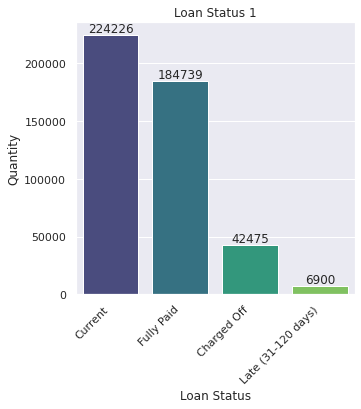

In [ ]:
sns.set(font_scale=1)
plt.rcParams["figure.figsize"] = [5.00, 5.00]

# Bar graph with Current, Fully Paid, Charged Off and Late (31-120 days)
loan_status_graph1 = sns.barplot(x=loan_status['Loan Status'][:4],y='Quantity',
                               data=loan_status,palette='viridis')
loan_status_graph1.bar_label(loan_status_graph1.containers[0])

plt.title('Loan Status 1')
plt.xticks(
    rotation=45, 
    horizontalalignment='right'  
)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'In Grace Period'),
  Text(1, 0, 'Does not meet the credit policy. Status:Fully Paid'),
  Text(2, 0, 'Late (16-30 days)'),
  Text(3, 0, 'Default'),
  Text(4, 0, 'Does not meet the credit policy. Status:Charged Off')])

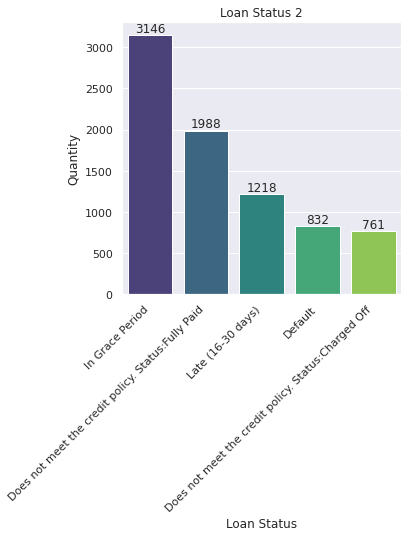

In [ ]:
sns.set(font_scale=1)
plt.rcParams["figure.figsize"] = [5.00, 5.00]

# Bar graph with
loan_status_graph2 = sns.barplot(x=loan_status['Loan Status'][4:],y='Quantity',
                               data=loan_status,palette='viridis')
loan_status_graph2.bar_label(loan_status_graph2.containers[0])

plt.title('Loan Status 2')
plt.xticks(
    rotation=45, 
    horizontalalignment='right'  
)

Al observar los gráficos de barras, se concluye que las personas por lo general tienen un crédito actual o lo han pagado por completo (Véase Loan Status 1).

Ahora, se calcula la cantidad de personas en el estado Default y las que no están con aquel estado. En el caso de Default se considera que, aquellos que tienen el estado Late (31-120 days), también entran en Default.

In [ ]:
analisis['loan_status'].value_counts().reset_index()
loanhist = pd.DataFrame()
loanhist['Loan Status'] = ['Default' if ((status == 'Default') or 
                                         (status == 'Late (31-120 days)')) else
                            'Not Default' for status in analisis['loan_status']]

In [ ]:
loanhist.value_counts()

Loan Status
Not Default    458553
Default          7732
dtype: int64

Al ver los resultados, se concluye que la gran mayoría que solicitaron crédito no se encuentran en estado de Default, es decir que cumplen con sus obligaciones financieras.

### Propiedad de la vivienda

El tipo de propiedad de vivienda puede influenciar en la solicitud de crédito. Aquí se muestra, por medio de una gráfica de barras, la cantidad de personas que solicitaron crédito según su tipo de propiedad de vivienda. 

La propiedad de vivienda se clasifica de la siguiente manera: MORTGAGE (Hipoteca), RENT (Renta), OWN (Propietario), OTHER (Otro), NONE (Ninguno) o ANY (Alguno).

In [ ]:
ownership = analisis['home_ownership'].value_counts().reset_index()
ownership.rename(columns={'index':'Home Ownership','home_ownership':'Quantity'}, inplace=True)

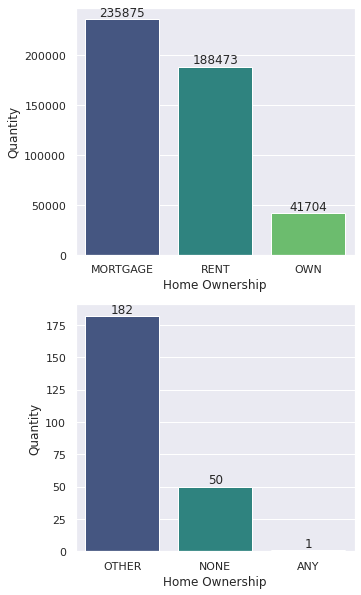

In [ ]:
sns.set(font_scale=1)
plt.rcParams["figure.figsize"] = [5.00, 10.00]
f, axes = plt.subplots(2, 1)

# Bar graph with MORTGAGE, RENT y OWN
ownership_graph1 = sns.barplot(x=ownership['Home Ownership'][:3],y='Quantity',
                               data=ownership,palette='viridis',ax=axes[0])
ownership_graph1.bar_label(ownership_graph1.containers[0])
# Bar graph with OTHER, NONE y ANY
ownership_graph2 = sns.barplot(x=ownership['Home Ownership'][3:],y='Quantity',
                               data=ownership,palette='viridis',ax=axes[1])
ownership_graph2.bar_label(ownership_graph2.containers[0])

plt.show()

Se realizaron dos gráficos de barras debido a que la escala del primer gráfico no permitía ver la cantidad de datos de algunos tipos de propiedad. Ahora, se observa que la mayoría de personas que solicitaron crédito viven en hipoteca o rentan.

### Estado donde reside el solicitante

Los siguientes son estados de EEUU donde residen los solicitantes de crédito: 

California (CA), New York (NY), Texas (TX), Florida (FL), Illinois (IL), New Jersey (NJ), Pensilvania (PA), Ohio (OH), Georgia (GA), Virginia (VA), North Carolina (NC), Michigan (MI), Massachusetts (MA), Maryland (MD), Arizona (AZ), Washington (WA), Colorado (CO), Minnesota (MN), Missouri (MO), Connecticut (CT), Indiana (IN), Nevada (NV), Tennessee (TN), Oregon (OR), Wisconsin (WI), Alabama (AL), South Carolina (SC), Louisiana (LA), Kentucky (KY), Kansas (KS), Oklahoma (OK), Arkansas (AR), Utah (UT), New Mexico (NM), Hawaii (HI), West Virginia (WV), New Hampshire (NH), Rhoad Island (RI), District of Columbia (DC), Montana (MT), Delaware (DE), Alaska (AK), Mississippi (MS), Wyoming (WY), South Dakota (SD), Vermont (VT), Iowa (IA), Nebraska (NE), Idaho (ID) y Maine (ME).

In [ ]:
states = analisis['addr_state'].value_counts().reset_index()
states.rename(columns={'index':'States','addr_state':'Quantity'}, inplace=True)

[Text(0, 0, '1272'),
 Text(0, 0, '1251'),
 Text(0, 0, '1226'),
 Text(0, 0, '1128'),
 Text(0, 0, '980'),
 Text(0, 0, '905'),
 Text(0, 0, '14'),
 Text(0, 0, '14'),
 Text(0, 0, '12'),
 Text(0, 0, '4')]

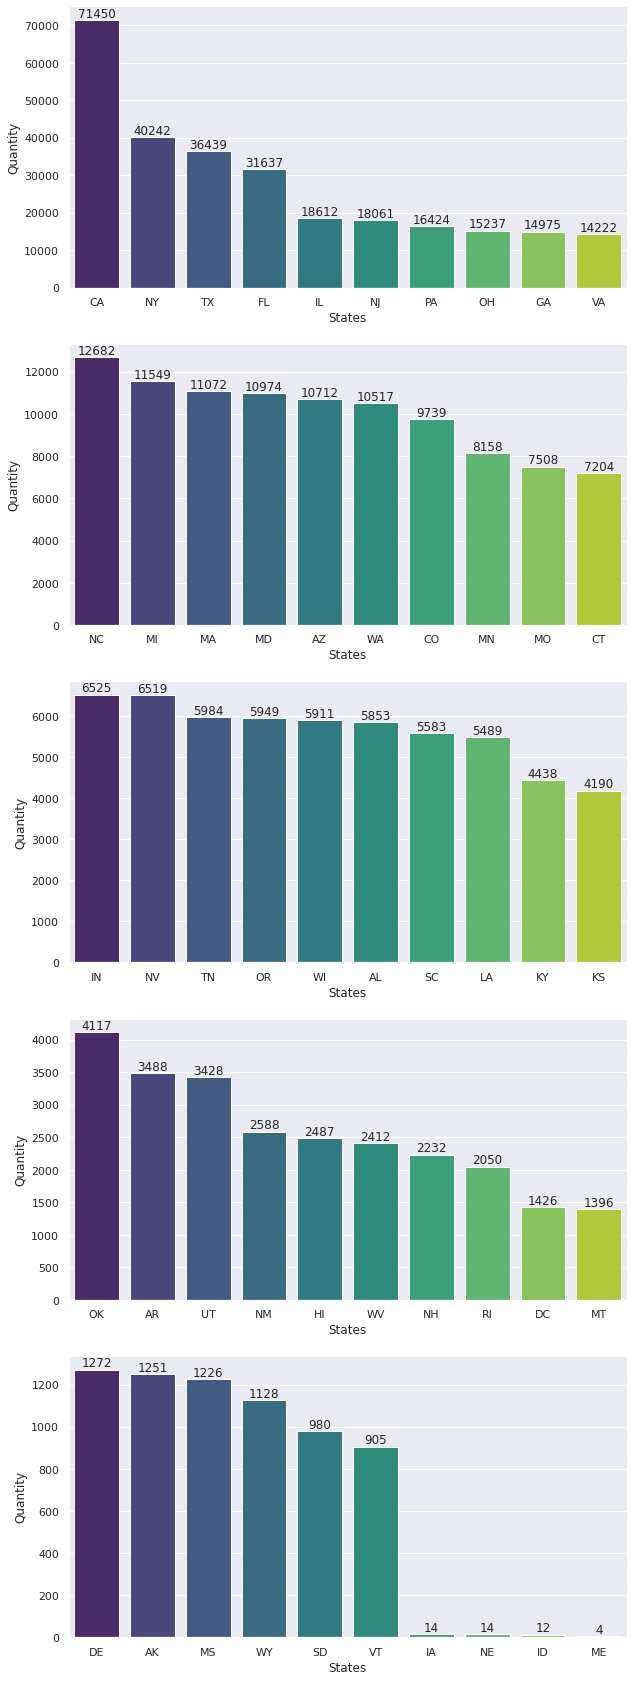

In [ ]:
sns.set(font_scale=1)
plt.rcParams["figure.figsize"] = [10.00, 30.00]
f, axes = plt.subplots(5, 1)

# Bar graph for the states
states_graph1 = sns.barplot(x=states['States'][:10],y='Quantity',
                               data=states,palette='viridis', ax=axes[0])
states_graph1.bar_label(states_graph1.containers[0])
states_graph1 = sns.barplot(x=states['States'][10:20],y='Quantity',
                               data=states,palette='viridis', ax=axes[1])
states_graph1.bar_label(states_graph1.containers[0])
states_graph1 = sns.barplot(x=states['States'][20:30],y='Quantity',
                               data=states,palette='viridis', ax=axes[2])
states_graph1.bar_label(states_graph1.containers[0])
states_graph1 = sns.barplot(x=states['States'][30:40],y='Quantity',
                               data=states,palette='viridis', ax=axes[3])
states_graph1.bar_label(states_graph1.containers[0])
states_graph1 = sns.barplot(x=states['States'][40:],y='Quantity',
                               data=states,palette='viridis', ax=axes[4])
states_graph1.bar_label(states_graph1.containers[0])

Al ver la gráfica de barras podemos concluír que el estado donde hay más personas que solicitaron crédito es California.

##Preprocesamiento de datos


Se eliminan las columnas que contienen valores nulos (NaN) en su totalidad, ya que no aportarían al modelo a crear.

In [ ]:
df.dropna(axis=1,how='all',inplace=True)

Se observa que hay gran diversidad de empleos, por ello se eliminarán las variables 'emp_title', 'desc' y 'title'.

In [ ]:
#Se nota que hay muchos empleos para usarlos como variable categorica, 
#por este motivo se borraran 'emp_title', 'desc','title'
df['emp_title'].value_counts()

Teacher                              5399
Manager                              4438
Registered Nurse                     2316
RN                                   2204
Supervisor                           1967
                                     ... 
The Eastern Arizona AHEC                1
Delaware Quarries.com                   1
McCauley trucking and warehousing       1
save mart supermarkets                  1
Server Engineer Lead                    1
Name: emp_title, Length: 205475, dtype: int64

A continuación se crean las funciones change_time_lapse() y fix_date(). change_time_lapse() permite extraer la cantidad de años de la variable emp_length. fix_date() modifica el formato de fecha de la fecha recibida.

In [ ]:
def change_time_lapse(emp_length):
  if('10+ years' == emp_length):
    return 10
  if('< 1 year' == emp_length):
    return 0
  if('1 year' == emp_length):
    return 1
  if('3 years' == emp_length):
    return 3
  if('8 years' == emp_length):
    return 8
  if('9 years' == emp_length):
    return 9
  if('4 years'== emp_length):
    return 4
  if('5 years' == emp_length):
    return 5
  if('6 years' == emp_length):
    return 6
  if('2 years' == emp_length):
    return 2
  if('7 years' == emp_length):
    return 7
  return -1

def fix_date(date):
  if(type(date)!=str):
    if math.isnan(date) == True:
      return date
  date = date.replace('-',' ')
  date= date.split(' ')
  if (int(date[1]) >=0 and int(date[1]) <=22):
    date[1]= '20'+ (date[1])
  else:
    date[1]= '19'+ (date[1])
  date = ' '.join(date)
  return (datetime.datetime.strptime("{0}".format(date.replace('-',' ')), "%b %Y").strftime("%m-%Y"))

Se revisa la cantidad de valores nulos (Nan) en la columna emp_length

In [ ]:
df['emp_length'].isna().sum()

21008

Se usa la función change_time_lapse para realizar la transformación del tiempo que el empleado(a) lleva en su trabajo actual.

In [ ]:
df['emp_length'] = df.emp_length.apply(change_time_lapse)

Se cambia el formato de algunas columnas que contienen fechas.

In [ ]:
df['earliest_cr_line'] = df.earliest_cr_line.apply(fix_date)
df['last_pymnt_d'] = df.last_pymnt_d.apply(fix_date)
df['next_pymnt_d'] = df.next_pymnt_d.apply(fix_date)
df['last_credit_pull_d'] = df.last_credit_pull_d.apply(fix_date)

In [ ]:
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format="%m-%Y")
df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'], format="%m-%Y")
df['next_pymnt_d'] = pd.to_datetime(df['next_pymnt_d'], format="%m-%Y")
df['last_credit_pull_d'] = pd.to_datetime(df['last_credit_pull_d'], 
                                          format="%m-%Y")

Se crean nuevas columnas extrayendo el año de las fechas a las que previamente se aplicó el formato con la función fix_date.

In [ ]:
df['earliest_cr_line_Y'] = pd.to_datetime(df['earliest_cr_line']).dt.year
df['last_pymnt_d_Y'] = pd.to_datetime(df['last_pymnt_d']).dt.year
df['next_pymnt_d_Y'] = pd.to_datetime(df['next_pymnt_d']).dt.year
df['last_credit_pull_d_Y'] = pd.to_datetime(df['last_credit_pull_d']).dt.year

Basado en la revisión hecha anteriormente se proceden a eliminar las siguientes columnas: 'emp_title', 'desc','title','earliest_cr_line','last_pymnt_d','next_pymnt_d','last_credit_pull_d'.

In [ ]:
#Se eliminan las columnas que son variables categoricas con demasiadas opciones unicas
data = df.drop(['emp_title', 'desc','title','earliest_cr_line','last_pymnt_d','next_pymnt_d','last_credit_pull_d'], axis = 1)

Se eliminan las columnas: 'id','member_id','grade','url','zip_code','application_type','addr_state' ya que se consideran poco aportantes para la predicción del riesgo de crédito.

In [ ]:
data.drop(['id','member_id','grade','url','zip_code','application_type','addr_state'], axis=1, inplace=True)

Se observan las columnas de tipo 'object' para proceder a realizar transformaciones a la columnas o eliminación de estas según sea el caso.

In [ ]:
data.select_dtypes("object").columns

Index(['term', 'sub_grade', 'home_ownership', 'verification_status', 'issue_d',
       'loan_status', 'pymnt_plan', 'purpose', 'initial_list_status'],
      dtype='object')

Se realizan las transformaciones de los tipos de las columnas y eliminaciones necesarias.

In [ ]:
data['issue_d'] = data.issue_d.apply(fix_date)
data['issue_d'] = pd.to_datetime(data['issue_d'], format="%m-%Y")
data['issue_d_Y'] = pd.to_datetime(data['issue_d']).dt.year
data.drop(['issue_d'], axis=1, inplace=True)

In [ ]:
term_values = {' 36 months': 36, ' 60 months': 60}
data['term'] = data.term.map(term_values)

Se crean los dummies a partir de las variables 'sub_grade','home_ownership','verification_status','pymnt_plan','purpose','initial_list_status' para su posterior utilización en los modelos.

In [ ]:
dummies = ['sub_grade','home_ownership','verification_status','pymnt_plan','purpose','initial_list_status']
data = pd.get_dummies(data, columns=dummies, drop_first=True)

Se muestran las columnas que contienen valores nulos (NaN) y cuales son sus valores con el fin de revisar cuales columnas eliminar en caso de ser necesario.

In [ ]:
for i in data.columns:
  if data[i].isnull().values.any():
    print(i,'Los valores estos: ',pd.unique(df[i]),'\n'*2,
          'Cantidad de datos unicos en la columna: ',len(df[i].unique()),'\n'*2)

annual_inc Los valores estos:  [ 24000.  30000.  12252. ... 284481. 113926.  72787.] 

 Cantidad de datos unicos en la columna:  31902 


delinq_2yrs Los valores estos:  [ 0.  2.  3.  1.  4.  6.  5.  8.  7.  9. 11. nan 13. 15. 10. 12. 17. 18.
 29. 24. 14. 21. 22. 19. 16.] 

 Cantidad de datos unicos en la columna:  25 


inq_last_6mths Los valores estos:  [ 1.  5.  2.  0.  3.  4.  6.  7.  8.  9. 10. 11. 12. 15. 14. 33. 17. 32.
 24. 13. 18. 16. 31. 28. 25. 27. 20. 19. nan] 

 Cantidad de datos unicos en la columna:  29 


mths_since_last_delinq Los valores estos:  [ nan  35.  38.  61.   8.  20.  18.  68.  45.  48.  41.  40.  74.  25.
  53.  39.  10.  26.  56.  77.  28.  52.  24.  16.  60.  54.  23.   9.
  11.  13.  65.  19.  80.  22.  59.  79.  44.  64.  57.  14.  63.  49.
  15.  73.  70.  29.  51.   5.  75.  55.   2.  30.  47.  33.  69.   4.
  43.  21.  27.  46.  81.  78.  82.  31.  76.  62.  72.  42.  50.   3.
  12.  67.  36.  34.  58.  17.  71.  66.  32.   6.  37.   7.   1.  83.
  86

Se muestran los porcentajes de valores faltantes de las columnas con el fin de revisar cuales columnas eliminar en caso de ser necesario.

In [ ]:
#Se revisa el % de valores faltante en cada una de las variables a analizar
for column in data.columns:
    if data[column].isna().sum() != 0:
        missing = data[column].isna().sum()
        portion = (missing / data.shape[0]) * 100
        print(f"'{column}': number of missing values '{missing}' ==> '{portion:.3f}%'")

'annual_inc': number of missing values '4' ==> '0.001%'
'delinq_2yrs': number of missing values '29' ==> '0.006%'
'inq_last_6mths': number of missing values '29' ==> '0.006%'
'mths_since_last_delinq': number of missing values '250351' ==> '53.691%'
'mths_since_last_record': number of missing values '403647' ==> '86.567%'
'open_acc': number of missing values '29' ==> '0.006%'
'pub_rec': number of missing values '29' ==> '0.006%'
'revol_util': number of missing values '340' ==> '0.073%'
'total_acc': number of missing values '29' ==> '0.006%'
'collections_12_mths_ex_med': number of missing values '145' ==> '0.031%'
'mths_since_last_major_derog': number of missing values '367311' ==> '78.774%'
'acc_now_delinq': number of missing values '29' ==> '0.006%'
'tot_coll_amt': number of missing values '70276' ==> '15.071%'
'tot_cur_bal': number of missing values '70276' ==> '15.071%'
'total_rev_hi_lim': number of missing values '70276' ==> '15.071%'
'earliest_cr_line_Y': number of missing values '

In [ ]:
data.drop(['next_pymnt_d_Y','mths_since_last_major_derog','total_rev_hi_lim','mths_since_last_record','mths_since_last_delinq'], axis=1,inplace=True)

Se llenan los valores nulos (NaN) de las columnas: 'tot_coll_amt' y 'tot_cur_bal' con la media debido a que su porcentaje no es tan alto como para eliminar la columna ni tan bajo para borrar las filas que tienen el valor nulo.

In [ ]:
data['tot_coll_amt'].fillna((data['tot_coll_amt'].mean()), inplace=True)
data['tot_cur_bal'].fillna((data['tot_cur_bal'].mean()), inplace=True)

Se eliminan las filas que contienen valores nulos (NaN) ya que su porcentaje de valores faltantes es pequeño.

In [ ]:
data.dropna(inplace=True)

Se tranforma la variables 'loan_status' para que sea una variable binaria ya que con esta se realizará la predicción.

In [ ]:
data['loan_status'] = [1 if ((status == "Default") or (status == "Late (31-120 days)")) else 0 for status in data['loan_status']]

In [ ]:
data.select_dtypes('int').columns

Index(['loan_amnt', 'funded_amnt', 'term', 'emp_length', 'loan_status',
       'revol_bal', 'policy_code', 'issue_d_Y'],
      dtype='object')

A continuación se observa una muestra del conjunto de datos con el preprocesamiento realizado.

In [ ]:
data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,loan_status,dti,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_w
0,5000,5000,4975.0,36,10.65,162.87,10,24000.0,0,27.65,...,0,0,0,0,0,0,0,0,0,0
1,2500,2500,2500.0,60,15.27,59.83,0,30000.0,0,1.00,...,0,0,0,0,0,0,0,0,0,0
2,2400,2400,2400.0,36,15.96,84.33,10,12252.0,0,8.72,...,0,0,0,0,0,0,1,0,0,0
3,10000,10000,10000.0,36,13.49,339.31,10,49200.0,0,20.00,...,0,0,0,0,1,0,0,0,0,0
4,3000,3000,3000.0,60,12.69,67.79,1,80000.0,0,17.94,...,0,0,0,0,1,0,0,0,0,0


##Selección de características para ambos modelos

Previo a la realización de los modelos se revisó la correlación de las variables con la variable 'loan_status' (variable a predecir) con la intención de realizar la selección de características; sin embargo, al haber poca correlación entre las variables y la variable 'loan_status' se descartó este método para realizar la selección de características.

In [ ]:
correlations = data.corr()
correlations['loan_status'].sort_values(ascending=False)

loan_status           1.000000
out_prncp             0.116107
out_prncp_inv         0.116106
total_rec_late_fee    0.095745
int_rate              0.063779
                        ...   
total_pymnt_inv      -0.042538
total_pymnt          -0.043473
last_pymnt_amnt      -0.061365
total_rec_prncp      -0.063752
policy_code                NaN
Name: loan_status, Length: 92, dtype: float64

##Modelo de predicción de riesgo de crédito utilizando Redes Neuronales


Se realiza un modelo utilziando redes neuronales para realizar la predicción de riesgo de crédito basado en el modelo presentado en: https://www.kaggle.com/code/faressayah/lending-club-loan-defaulters-prediction/notebook 

###Selección de características

Para este modelo de realizó una selección de características más granular debido a que para el uso del modelo de red neuronal el tener pocas características podría ser perjudicial a la hora de realizar el proceso de entrenamiento, ya que podría causar que las capaz ocultas realicen inferencias demasiado simplificadas de la realidad. Por lo cual se usaron todas las variables que contiene el conjunto de datos después de realizado el preprocesamiento.



###Separación del conjunto de datos

Se separa el conjunto de datos en los conjuntos de entrenamiento y validación.



In [ ]:
trainNN, testNN = train_test_split(data, test_size=0.33, random_state=42)

print(trainNN.shape)
print(testNN.shape)

(311832, 92)
(153590, 92)


In [ ]:
X_trainNN, y_trainNN = trainNN.drop('loan_status', axis=1), trainNN.loan_status
X_testNN, y_testNN = testNN.drop('loan_status', axis=1), testNN.loan_status

###Normalización de los datos

Seguidamente normalizan los datos.

In [ ]:
scaler = MinMaxScaler()
X_trainNN = scaler.fit_transform(X_trainNN)
X_testNN = scaler.transform(X_testNN)

In [ ]:
X_trainNN = np.array(X_trainNN).astype(np.float32)
X_testNN = np.array(X_testNN).astype(np.float32)
y_trainNN = np.array(y_trainNN).astype(np.float32)
y_testNN = np.array(y_testNN).astype(np.float32)

###Entrenamiento del modelo

Se utilizan los métodos para entrenar el modelo de redes neuronales.

In [ ]:
def evaluate_nn(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")

def nn_model(num_columns, num_labels, hidden_units, dropout_rates, learning_rate):
    inp = tf.keras.layers.Input(shape=(num_columns, ))
    x = BatchNormalization()(inp)
    x = Dropout(dropout_rates[0])(x)
    for i in range(len(hidden_units)):
        x = Dense(hidden_units[i], activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rates[i + 1])(x)
    x = Dense(num_labels, activation='sigmoid')(x)
  
    model = Model(inputs=inp, outputs=x)
    model.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy', metrics=[AUC(name='AUC')])
    return model

In [ ]:
num_columns = X_trainNN.shape[1]
num_labels = 1
hidden_units = [150, 150, 150]
dropout_rates = [0.1, 0, 0.1, 0]
learning_rate = 1e-3


model = nn_model(
    num_columns=num_columns, 
    num_labels=num_labels,
    hidden_units=hidden_units,
    dropout_rates=dropout_rates,
    learning_rate=learning_rate
)

In [ ]:
r = model.fit(
    X_trainNN, y_trainNN,
    validation_data=(X_testNN, y_testNN),
    epochs=20,
    batch_size=32
)

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
9742/9745 [============================>.] - ETA: 0s - loss: 0.0683 - AUC: 0.8801WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f1a2bdb9560> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the v

Se realiza la predicción de la variable 'loan_status'.

In [ ]:
y_trainNN_pred = model.predict(X_trainNN) 

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7f19fde7d450>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7f19fde7d450>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
y_testNN_pred = model.predict(X_testNN)

###Evaluación del modelo

A continuación se presentan las métricas obtenidas con el modelo de redes neuronales.



In [ ]:
evaluate_nn(y_trainNN, y_trainNN_pred.round(), train=True)

Train Result:
Accuracy Score: 98.42%
_______________________________________________
CLASSIFICATION REPORT:
                     0.0          1.0  accuracy      macro avg   weighted avg
precision       0.984380     0.825858  0.984187       0.905119       0.981747
recall          0.999785     0.060448  0.984187       0.530116       0.984187
f1-score        0.992022     0.112651  0.984187       0.552337       0.977420
support    306654.000000  5178.000000  0.984187  311832.000000  311832.000000
_______________________________________________


In [ ]:
evaluate_nn(y_testNN, y_testNN_pred.round(), train=False)

Test Result:
Accuracy Score: 98.39%
_______________________________________________
CLASSIFICATION REPORT:
                     0.0          1.0  accuracy      macro avg   weighted avg
precision       0.984155     0.728395  0.983886       0.856275       0.979911
recall          0.999709     0.046293  0.983886       0.523001       0.983886
f1-score        0.991871     0.087053  0.983886       0.539462       0.976855
support    151041.000000  2549.000000  0.983886  153590.000000  153590.000000
_______________________________________________


###Exportación del modelo

Se exporta el modelo para poder ser usado en producción.

In [ ]:
import joblib
joblib_model_file = "modelNN.pkl"
joblib.dump(model, joblib_model_file)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('signature_function', 'signature_key'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('signature_function', 'signature_key'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: ram://06377a19-d7fb-4608-bb36-e06149316540/assets


['modelNN.pkl']

Se verifica que el modelo haya sido exportado correctamente.

In [ ]:
#Calculate the accuracy and predictions of the exported model
#to verify the model was exported correctly
joblib_model = joblib.load(joblib_model_file)

y_trainNN_pred = joblib_model.predict(X_trainNN)
evaluate_nn(y_trainNN, y_trainNN_pred.round(), train=True)

y_testNN_pred = joblib_model.predict(X_testNN)
evaluate_nn(y_testNN, y_testNN_pred.round(), train=False)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7f19fcb461d0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7f19fcb461d0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Train Result:
Accuracy Score: 98.42%
_______________________________________________
CLASSIFICATION REPORT:
                     0.0          1.0  accuracy      macro avg   weighted avg
precision       0.984380     0.825858  0.984187       0.905119       0.981747
recall          0.999785     0.060448  0.984187       0.530116       0.984187
f1-score        

##Modelo de predicción de riesgo de crédito utilizando Regresión Logística

###Separación del conjunto de datos

Se separa el conjunto de datos en los conjuntos de entrenamiento y validación.


In [ ]:
trainLR, testLR = train_test_split(data, test_size=0.33, random_state=43)

print(trainLR.shape)
print(testLR.shape)

(311832, 92)
(153590, 92)


In [ ]:
X_trainLR, y_trainLR = trainLR.drop('loan_status', axis=1), trainLR.loan_status
X_testLR, y_testLR = testLR.drop('loan_status', axis=1), testLR.loan_status

###Selección de características 

Se utiliza el método RFE para realizar la selección de características debido a que su objetivo es seleccionar características considerando de forma recursiva conjuntos de características cada vez más pequeños.

In [ ]:
logreg = LogisticRegression()
rfe = RFE(logreg, n_features_to_select=10)
rfe = rfe.fit(X_trainLR, y_trainLR.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[False  True  True False False  True False False False False False False
 False False False False  True  True  True  True False  True  True  True
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False]
[11  1  1 12 44  1  5 16 45 18 17  4 28 14 34 61  1  1  1  1  7  1  1  1
 10  6 49 20 78 13 15  3  2  9  8 30 31 25 26 27 35 29 39 71 72 55 77 57
 53 32 42 54 40 33 47 41 63 46 79 51 64 52 60 70 68 65 76 80 73 21 82 81
 36 69 23 24 67 22 59 66 43 62 38 75 58 37 74 48 50 56 19]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Seguidamente se muestran las características seleccionadas con RFE para realizar el entrenamiento del modelo. 

In [ ]:
selected_features_i = np.where(rfe.ranking_ == 1)[0]

In [ ]:
data.columns[selected_features_i]

Index(['funded_amnt', 'funded_amnt_inv', 'installment', 'total_acc',
       'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee'],
      dtype='object')

Se modifican los conjuntos de datos de entrenamiento y de valdiación para que solo contengan las características seleccionadas.

In [ ]:
cols=X_trainLR.columns[selected_features_i]
X_trainLR = X_trainLR[cols]
X_testLR = X_testLR[cols]

###Enrenamiento del modelo

Se entrena el modelo de regresión lineal.

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_trainLR, y_trainLR)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

Se realiza la predicción de la variable 'loan_status'.

In [ ]:
y_predLR = logreg.predict(X_testLR)

###Evaluación del modelo

A continuación se presentan las métricas obtenidas con el modelo de regresión lineal.


In [ ]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_testLR, y_testLR)))

Accuracy of logistic regression classifier on test set: 0.98


In [ ]:
confusion_matrix = confusion_matrix(y_testLR, y_predLR)
print(confusion_matrix)

[[150841    243]
 [  2389    117]]


In [ ]:
print(classification_report(y_testLR, y_predLR))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    151084
           1       0.33      0.05      0.08      2506

    accuracy                           0.98    153590
   macro avg       0.65      0.52      0.54    153590
weighted avg       0.97      0.98      0.98    153590



##Conclusiones

* 
* 
*